# Homework neural networks

## Question 1 part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Inputs
data_folder = '/home/nao/bilhr23ss/workspace/src/tutorial_3/datasets/'

dataset = np.loadtxt(data_folder + 'data.txt')
trainX = dataset[:,:2]
trainY = dataset[:,2:]

hidden_units = 128
ss = 0.01
epochs = 200
batch_size = 100
lam = 0.0001
load = False
save = not load

In [10]:
dataset = np.loadtxt(data_folder + 'data.txt')
X = dataset[:,:2]
Y = dataset[:,2:]

In [3]:
dataset = np.loadtxt(data_folder + 'data.txt')
trainX = dataset[:,:2]
trainY = dataset[:,2:]

In [11]:
# Load data (get files from Piazza)
trainX = X[:,:45]
trainY = Y[:,:45]
testX = X[:,45:]
testY = Y[:,45:]
# Set seed
np.random.seed(0)

'''# Randomize training set and pick validation set
ind = np.random.choice(trainX.shape[0],size=trainX.shape[0],replace=False)
valX = trainX[ind[0:10000],:]
valY = trainY[ind[0:10000]]
trainX = trainX[10000:,:]
trainY = trainY[10000:]'''

'# Randomize training set and pick validation set\nind = np.random.choice(trainX.shape[0],size=trainX.shape[0],replace=False)\nvalX = trainX[ind[0:10000],:]\nvalY = trainY[ind[0:10000]]\ntrainX = trainX[10000:,:]\ntrainY = trainY[10000:]'

In [12]:
'''#Standardize
mean = trainX.mean()
std = trainX.std()
trainX = (trainX-mean)/std
valX = (valX-mean)/std
testX = (testX - mean)/std'''

'#Standardize\nmean = trainX.mean()\nstd = trainX.std()\ntrainX = (trainX-mean)/std\nvalX = (valX-mean)/std\ntestX = (testX - mean)/std'

In [4]:
#Batchs
num_batches = int( np.floor( trainY.size/batch_size ) )
BX = [trainX[(i*batch_size):((i+1)*batch_size)] for i in range(num_batches)]
BY = [trainY[(i*batch_size):((i+1)*batch_size)] for i in range(num_batches)]

ValueError: cannot reshape array of size 2 into shape (28,28)

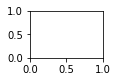

In [5]:
# Visualize
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.reshape(trainX[i],[28,28]), cmap='gray')
    plt.title(str(int(trainY[i,0])))
    plt.axis('off')
    
plt.show()

In [7]:
#Network class
class net(object):
    def __init__(self,L=300):
        #Constants
        self.dim_in = 2
        self.dim_out = 2
        
        #Initialize weights
        self.W1 = np.random.randn(L,self.dim_in)
        self.W2 = np.random.randn(self.dim_out,L)
        self.b1 = np.zeros([L,1])
        self.b2 = np.zeros([self.dim_out,1])
        
        #Initialize random stuff
        self.total_loss = []
        self.total_accuracy = []
        self.loss_val = []
        self.acc_val = []
        self.loss_train = []
        self.acc_train = []
        
    def sigmoid(self, x):
        temp = x*0
        ind = x >= 0 
        temp[ind] = 1/(1+np.exp(-x[ind]))
        ind = x < 0
        temp[ind ] = np.exp(x[ind])/(1+np.exp(x[ind]))
        return temp
    
    def softmax(self,x):
        x = np.exp(x-np.max(x))
        return x/x.sum()
    
    def softmax_der(self,x):
        #This is used for the derivative
        B = x.shape[1]
        temp = np.zeros([self.dim_out,B]) # x is shape 10 x B
        for i in range(B):
            temp[:,i] = self.softmax(x[:,i])
        
        #Make the return matrix
        ret = np.zeros([B,self.dim_out,self.dim_out])
        I = np.identity(self.dim_out)
        for i in range(self.dim_out):
            for ii in range(self.dim_out):
                ret[:,i,ii] = temp[i,:]*(I[i,ii] - temp[ii,:])
        
        return ret
    
    def forward(self,x):
        #Reshape
        x = x.transpose()
        self.x_0 = x + 0 #The initial x

        #Hidden layer
        x = np.matmul(self.W1,x) + self.b1
        self.x_1 = x + 0 #x after the fully connected layer
        x = self.sigmoid(x)
        self.x_sigmoid = x + 0 #x after the sigmoid
        
        #Output layers
        x = np.matmul(self.W2,x) + self.b2
        self.x_2 = x + 0 #x afte second fully connected layer
#        for i in range(x.shape[1]):
#            x[:,i] = self.softmax(x[:,i])
        
        return x.squeeze()
    
    def loss(self, y, y_hat):
        #For numeric stability
        tol = 1e-64
        y_hat[y_hat <= tol] = tol
        
        self.y_hat = y_hat + 0
        self.y_hat_pred = np.argmax(y_hat,0)
        self.y = y
        self.loss_val = 0
        for i in range(y.size):
            self.loss_val -= np.log(y_hat[y[i],i])
        self.loss_val /= y.size
            
        return self.loss_val
    
    def zero_grad(self):
        self.W1_grad = self.W1*0
        self.b1_grad = self.b1*0
        self.W2_grad = self.W2*0
        self.b2_grad = self.b2*0
        return 
    
    def step(self,step_size):
        self.W1 = self.W1 - ss*self.W1_grad
        self.b1 = self.b1 - ss*self.b1_grad
        self.W2 = self.W2 - ss*self.W2_grad
        self.b2 = self.b2 - ss*self.b2_grad
        return

    def backward(self, lam):
        #Batch size
        B = self.y.size
        
        #Calculate the jacobian of the loss
        J_L = np.zeros([B,self.dim_out])
        for i in range(B):
            J_L[i,self.y[i]] = -(1)/(self.y_hat[self.y[i],i])

        #Softmax
        J_SM = self.softmax_der(self.x_2)

        ## b2 grad 
        grad_temp1 = np.zeros([B,self.dim_out])
        for i in range(B):
            grad_temp1[i,:] = np.matmul(J_L[i,:],J_SM[i,:])
        self.b2_grad = grad_temp1.sum(0).reshape(-1,1)
        
        #W2 jacobian
        T = self.W2.shape[0]
        N = self.W2.shape[1]
        temp = np.zeros([B,N*T])
        for i in range(T):
            ind1 = i*(N)
            ind2 = ind1 + N
            temp[:,ind1:ind2] = grad_temp1[:,i].reshape(B,1) * self.x_sigmoid.transpose()
        self.W2_grad = temp.sum(0).reshape(self.W2.shape) + 0
                        
        #Temporary gradient that will be used later
        grad_temp2 = np.matmul(grad_temp1,self.W2)
        
        #Sigmoid jacobian
        temp = self.sigmoid(self.x_1).squeeze()
        J_sig = np.zeros([B,self.W1.shape[0],self.W1.shape[0]])
        for i in range(self.W1.shape[0]):
            J_sig[i,:,:] = np.diag(temp[:,i]*(1-temp[:,i]))
            
        # b1 grad
        grad_temp3 = np.zeros([B,J_sig.shape[2]])
        for i in range(B):
            grad_temp3[i,:] = np.matmul(grad_temp2[i,:].reshape(1,-1),J_sig[i,:,:])
        self.b1_grad = grad_temp3.sum(0).reshape(-1,1)

        #W1 jacobian
        T = self.W1.shape[0]
        N = self.W1.shape[1]
        temp = np.zeros([B,N*T])
        for i in range(T):
            ind1 = i*(N)
            ind2 = ind1 + N
            temp[:,ind1:ind2] = grad_temp3[:,i].reshape(B,1) * self.x_0.transpose()
        self.W1_grad = temp.sum(0).reshape(self.W1.shape) + 0
    
        #Add regularization
        self.W1_grad += lam*self.W1
        self.W2_grad += lam*self.W2
    
        #Clip if gradient exploded
        tol = 1000
        self.W1_grad[self.W1_grad > tol] = tol
        self.W1_grad[self.W1_grad < -tol] = -tol
        self.b1_grad[self.b1_grad > tol] = tol
        self.b1_grad[self.b1_grad < -tol] = -tol
        self.W2_grad[self.W2_grad > tol] = tol
        self.W2_grad[self.W2_grad < -tol] = -tol
        self.b2_grad[self.b2_grad > tol] = tol
        self.b2_grad[self.b2_grad < -tol] = -tol
    
        return
    
    def save(self, filename):
        np.savez(filename, self.W1, self.b1, self.W2, self.b2, self.total_loss, self.total_accuracy, self.loss_val, self.acc_val, self.loss_train, self.acc_train)
        return
    
    def load(self, filename):
        temp = np.load(filename)
        self.W1 = temp['arr_0']
        self.b1 = temp['arr_1']
        self.W2 = temp['arr_2']
        self.b2 = temp['arr_3']
        
        self.total_loss = temp['arr_4']
        self.total_accuracy = temp['arr_5']
        self.loss_val = temp['arr_6']
        self.acc_val = temp['arr_7']
        self.loss_train = temp['arr_8']
        self.acc_train = temp['arr_9']
        return

In [8]:
#Make the network
model = net(300)

In [9]:
if load == True:
    model.load(models_folder + 'model1.npz')
else:
    #Initialize stats arrays
    loss = np.zeros([epochs,len(BX)])
    acc = np.zeros([epochs,len(BX)])
    loss_val = np.zeros([epochs,1])
    acc_val = np.zeros([epochs,1])
    loss_train = np.zeros([epochs,1])
    acc_train = np.zeros([epochs,1])
    
    #Loop through data
    for epoch in range(epochs):
        for batch in range(len(BX)):
            #Make back
            X = BX[batch]
            Y = BY[batch]
            
            #Zero out the gradient
            model.zero_grad()
            
            #Forward
            out = model.forward(X)

            #calculate loss and accuracy
            loss[epoch,batch] = model.loss(Y.astype(int)[:,0],out)
            acc[epoch,batch] = np.mean(model.y_hat_pred == model.y)

            #Backward
            model.backward(0)

            #Update weights
            model.step(ss)
            
        #Calcualte the validation loss and stuff
        model.zero_grad()
        out = model.forward(valX)
        loss_val[epoch] = model.loss(valY.astype(int)[:,0],out)
        acc_val[epoch] = np.mean(model.y_hat_pred == model.y)

        #Calcualte over the whole training set
        model.zero_grad()
        out = model.forward(trainX)
        loss_train[epoch] = model.loss(trainY.astype(int)[:,0],out)
        acc_train[epoch] = np.mean(model.y_hat_pred == model.y)
        print('Epoch ' + str(epoch+1) + '... loss = ' + str(loss_train[epoch,0]) + '... acc = ' + str(acc_train[epoch,0]))
        
    #Save stats
    model.total_loss = loss + 0
    model.total_accuracy = acc + 0
    model.loss_val = loss_val + 0
    model.acc_val = acc_val + 0
    model.loss_train = loss_train + 0
    model.acc_train = acc_train + 0
    
    #Save network
    if save == True:
        model.save(models_folder + 'model1.npz')

Epoch 1... loss = 1.8657310701847638... acc = 0.71034
Epoch 2... loss = 1.3389992319524244... acc = 0.78006
Epoch 3... loss = 1.1076962800573718... acc = 0.81026
Epoch 4... loss = 0.967782015371616... acc = 0.82882
Epoch 5... loss = 0.8684688405344192... acc = 0.8412
Epoch 6... loss = 0.7926711663901658... acc = 0.8518
Epoch 7... loss = 0.7328736061071679... acc = 0.85976
Epoch 8... loss = 0.6840554891675168... acc = 0.86626
Epoch 9... loss = 0.6434103389491722... acc = 0.87146
Epoch 10... loss = 0.6089371924394151... acc = 0.87556
Epoch 11... loss = 0.5791629040897235... acc = 0.87952
Epoch 12... loss = 0.5530309843316027... acc = 0.8835
Epoch 13... loss = 0.5297744288476697... acc = 0.88672
Epoch 14... loss = 0.5088590360786714... acc = 0.88938
Epoch 15... loss = 0.4899359979630934... acc = 0.89234
Epoch 16... loss = 0.47276589497811117... acc = 0.8948
Epoch 17... loss = 0.45715007377982847... acc = 0.89668
Epoch 18... loss = 0.4429025139700096... acc = 0.89886
Epoch 19... loss = 0.4

### Plots for part 1

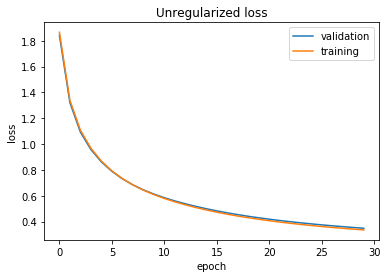

In [10]:
plt.plot(loss_val)
plt.plot(loss_train)
plt.legend(['validation','training'])
plt.title('Unregularized loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

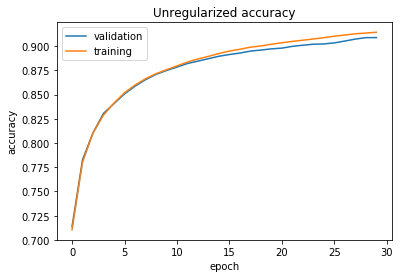

In [11]:
plt.plot(acc_val)
plt.plot(acc_train)
plt.legend(['validation','training'])
plt.title('Unregularized accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Part 2

In [12]:
#Make the network
model = net(300)

In [13]:
if load == True:
    model.load(models_folder + 'model2.npz')

else:
    #Initialize stats arrays
    loss = np.zeros([epochs,len(BX)])
    acc = np.zeros([epochs,len(BX)])
    loss_val = np.zeros([epochs,1])
    acc_val = np.zeros([epochs,1])
    loss_train = np.zeros([epochs,1])
    acc_train = np.zeros([epochs,1])
    
    #Loop through data
    for epoch in range(epochs):
        for batch in range(len(BX)):
            #Make back
            X = BX[batch]
            Y = BY[batch]
            
            #Zero out the gradient
            model.zero_grad()
            
            #Forward
            out = model.forward(X)

            #calculate loss and accuracy
            loss[epoch,batch] = model.loss(Y.astype(int)[:,0],out)
            acc[epoch,batch] = np.mean(model.y_hat_pred == model.y)

            #Backward
            model.backward(lam)

            #Update weights
            model.step(ss)
            
        #Calcualte the validation loss and stuff
        model.zero_grad()
        out = model.forward(valX)
        loss_val[epoch] = model.loss(valY.astype(int)[:,0],out)
        acc_val[epoch] = np.mean(model.y_hat_pred == model.y)

        #Calcualte over the whole training set
        model.zero_grad()
        out = model.forward(trainX)
        loss_train[epoch] = model.loss(trainY.astype(int)[:,0],out)
        acc_train[epoch] = np.mean(model.y_hat_pred == model.y)
        print('Epoch ' + str(epoch+1) + '... loss = ' + str(loss_train[epoch,0]) + '... acc = ' + str(acc_train[epoch,0]))

    #Save stats
    model.total_loss = loss + 0
    model.total_accuracy = acc + 0
    model.loss_val = loss_val + 0
    model.acc_val = acc_val + 0
    model.loss_train = loss_train + 0
    model.acc_train = acc_train + 0
    
    #Save network
    if save == True:
        model.save(models_folder + 'model2.npz')

Epoch 1... loss = 1.8016349079832592... acc = 0.71774
Epoch 2... loss = 1.2926553987361167... acc = 0.78452
Epoch 3... loss = 1.0679840003266576... acc = 0.8144
Epoch 4... loss = 0.9304803399073631... acc = 0.83314
Epoch 5... loss = 0.8329247552712004... acc = 0.84592
Epoch 6... loss = 0.7585276403764625... acc = 0.8548
Epoch 7... loss = 0.6999157000573796... acc = 0.86304
Epoch 8... loss = 0.6525412314772421... acc = 0.86898
Epoch 9... loss = 0.6133033651266904... acc = 0.87424
Epoch 10... loss = 0.5800892917101558... acc = 0.87862
Epoch 11... loss = 0.5515006729985068... acc = 0.88284
Epoch 12... loss = 0.5265291175573369... acc = 0.8869
Epoch 13... loss = 0.5044480173236059... acc = 0.89046
Epoch 14... loss = 0.4847461119496797... acc = 0.8933
Epoch 15... loss = 0.4670549581254301... acc = 0.89648
Epoch 16... loss = 0.45108194049735095... acc = 0.89792
Epoch 17... loss = 0.4365869605654921... acc = 0.90022
Epoch 18... loss = 0.4233674026342119... acc = 0.90256
Epoch 19... loss = 0.4

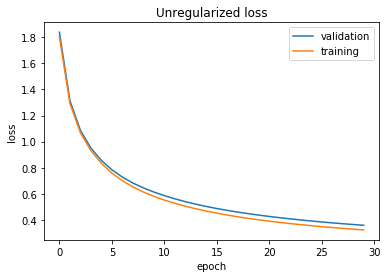

In [14]:
plt.plot(loss_val)
plt.plot(loss_train)
plt.legend(['validation','training'])
plt.title('Regularized loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

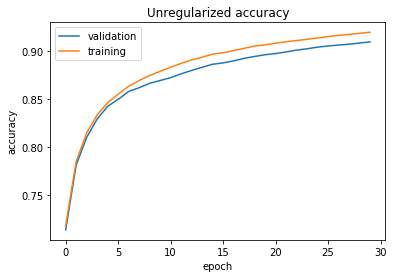

In [15]:
plt.plot(acc_val)
plt.plot(acc_train)
plt.legend(['validation','training'])
plt.title('Regularized accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Part 3

In [16]:
#Regularized model
out = model.forward(testX)
loss_reg = model.loss(testY.astype(int)[:,0],out)
acc_reg = np.mean(model.y_hat_pred == model.y)

In [17]:
#Unregularized model
model.load(models_folder + 'model1.npz')
out = model.forward(testX)
loss_unreg = model.loss(testY.astype(int)[:,0],out)
acc_unreg = np.mean(model.y_hat_pred == model.y)

In [18]:
#Show results
print('The accuracy of the unregularized model is ' + str(round(100*acc_unreg,1)) + '%')
print('The accuracy of the regularized model is ' + str(round(100*acc_reg,1)) + '%')

The accuracy of the unregularized model is 88.7%
The accuracy of the regularized model is 89.1%
